<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_5/Week_5_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import YouTubeVideo

# ML import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler       # Normalization
from sklearn.preprocessing import LabelEncoder       # Encoder
import torch                                   # PyTorch
import torch.nn as nn                          # PyTorch building blocks
from IPython.display import YouTubeVideo

# Neural Nets Examples

### Application: Predicting house prices

In this application, we will implement a Shallow Neural Network model with PyTorch to predict house prices using the [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

#### Data

In [7]:
# load data
raw_data = pd.read_csv("https://raw.githubusercontent.com/JasminaZHAW/MLDM2/main/labs/data/house_price.csv")
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
raw_data.shape

(1460, 81)

The dataset contains 81 columns. A description of the features is available in the file "[house_price_data_description](https://github.com/michalis0/DataScience_and_MachineLearning/blob/master/Week_5/data/house_price_data_description.txt)"

##### Preprocessing

Let's first extract the features of interest. We will use the numeric columns:

In [9]:
# Data types
raw_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [10]:
# Display numeric features (integer and floats)
numeric_columns = list(raw_data.columns[(raw_data.dtypes==np.int64) |
                 (raw_data.dtypes==np.float64)])
print(numeric_columns, "\n", len(numeric_columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
 38


`SalePrice` is the value we want to predict. We set it as the last column:

In [11]:
# Output SalePrice as last column
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

We also remove the `Id` column:

In [12]:
# Remove Id
numeric_columns.remove('Id')

Now we extract the numeric data.

In [13]:
# Extract numeric data
numeric_data = raw_data[numeric_columns]
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let's deal with the missing values in the data.

In [14]:
# Display features with missing values
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
nan_columns

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

We simply replace them with zero.

In [15]:
# Replace NAN with 0
numeric_data = numeric_data.fillna(0)

##### Creating training and test set

Let's split the data for training and test. We use the `train_test_split` module of `sklearn`:

In [16]:
# Splitting training/test set
numeric_data_train, numeric_data_test = train_test_split(numeric_data, test_size=0.1, random_state=7)

##### Normalizing the data

Before training our model, we need to normalize the data. We do this by subtracting each column from its minimum value and then dividing it by the difference between maximum and minimum. We use the `MinMaxScaler` of `sklearn`.

In [20]:
#Define the scaler
scaler = MinMaxScaler()
#Fit the scaler
scaler.fit(numeric_data_train)
#Transform the train and the test set
numeric_data_train.loc[:,:] = scaler.transform(numeric_data_train)
numeric_data_test.loc[:,:] = scaler.transform(numeric_data_test)

Finally, we split the column we want to predict ("SalePrice") to our features:

In [21]:
# Extract features and output
numeric_x_columns = list(numeric_data_train.columns)
numeric_x_columns.remove("SalePrice")
X_train_df = numeric_data_train[numeric_x_columns]
y_train_df = pd.DataFrame(numeric_data_train["SalePrice"])
X_test_df = numeric_data_test[numeric_x_columns]
y_test_df = pd.DataFrame(numeric_data_test["SalePrice"])

Ok, all set, we can start building our Neural Net!

#### Building a Shallow Neural Network model with PyTorch

We use the `PyTorch` library ([Documentation](https://pytorch.org/), imported at the beginning of this notebook with the following lines of codes:

```python
import torch
import torch.nn as nn
```

`torch.nn` contains the building blocks to build Neural Nets, e.g., the layers ([Documentation](https://pytorch.org/docs/stable/nn.html)).

##### Create tensors

The first step is to convert the data into torch tensors. A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type. It's very similar to arrays in `NumPy`.

We rely on `torch.tensor()` for the conversion ([Documentation](https://pytorch.org/docs/stable/tensors.html)).

In [22]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float)
y_train = torch.tensor(y_train_df.values, dtype=torch.float)
X_test = torch.tensor(X_test_df.values, dtype=torch.float)
y_test = torch.tensor(y_test_df.values, dtype=torch.float)

In [23]:
print(X_train.size(), y_train.size())

torch.Size([1314, 36]) torch.Size([1314, 1])


##### Define and train a model with PyTorch

A model is defined as a `class` in PyTorch. Classes are a means of bundling data and functionality together, allowing to create a new type of Python object. You can read the Python documentation on [Classes](https://docs.python.org/3/tutorial/classes.html) to learn more about them.

When you create your Neural Net, you should define:
- a `__init__` function in which you define the layers of your network.
- a `forward` function (method) that defines the forward pass on the network.

For the beginning, let's start with a single layer network:
- The layer `nn.Linear()` performs a linear transformation ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). The input and output are the number of neurons
- `nn.ReLU()` applies the Rectified Linear Unit function: $ReLU(x)=\max(0,x)$ ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [24]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)        # Linear transformation for hidden layer
        self.linear2 = nn.Linear(H1, D_out)       # Linear transformation for output layer
        self.activation = nn.ReLU()               # Activation function for hidden layer

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))   # Hidden layer: linear transformation + ReLU
        y_pred = self.linear2(y_pred)               # Output layer: linear transformation
        return y_pred

`D_in` is the input dimension, i.e., the number of features. Similarly, `D_out` is the output dimension, i.e., 1 (we only predict the "SalePrice"):

In [25]:
D_in, D_out = X_train.shape[1], y_train.shape[1]

Ok, let's define our first model. It is an instance of our newly-created class "Net". We are going to use 500 neurons for the hidden layer:

In [26]:
# Model with 500 neurons
model1 = Net(D_in, 500, D_out)

Let's calculate now how many parameters we have in the model.

In [27]:
# calculate how many parameters are in the model
pytorch_total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(pytorch_total_params)

19001


The next steps is to define the **loss criterion** and the **optimizer** for the network. That is, we have to define the loss function we want to optimize during training and also the optimization method. We use:
- `MSELoss()` as loss criterion, i.e., the mean square error ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html))
- `SGD()`as optimizer, i.e., stochastic gradient descent ([Documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))

In [28]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

Wonderful, we are ready to do the training! We can simply by looping over the number of iterations. The training has 3 main steps:
- A forward pass to compute the prediction for the current data point (batch).
- Computing the loss for the current prediction with the previously defined criterion.
- A backward pass to compute the gradient of the loss with respect to the weight of the network (`backward()`)
- Finally, updating the weights of the network (`optimizer.step()`).

Note that in each backward pass PyTorch saves the gradient for all of the parameters. Therefore it is important to replace the old gradient values with zero in the beginning of each iteration (`optimizer.zero_grad()`), otherwise the gradients will be accumulated during the iterations!

In [29]:
losses1 = []
losses1_test = []

for t in range(500):                # 500 iterations

    # Forward pass: compute prediction on training set
    y_pred = model1(X_train)

    # Compute loss
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses1.append(loss.item())
    if torch.isnan(loss):
        break

    # Compute gradient
    optimizer.zero_grad()
    loss.backward()

    # Update
    optimizer.step()

    # Compute loss on test set
    losses1_test.append(criterion(model1(X_test), y_test).item())

0 125.18836212158203
1 986.0961303710938
2 7191.044921875
3 10309.2119140625
4 367.5595703125
5 199.77020263671875
6 112.40000915527344
7 66.64415740966797
8 42.60814666748047
9 29.94753074645996
10 23.254432678222656
11 19.694360733032227
12 17.779953002929688
13 16.73023223876953
14 16.135005950927734
15 15.77889633178711
16 15.548717498779297
17 15.38491153717041
18 15.2562255859375
19 15.14639663696289
20 15.046802520751953
21 14.952821731567383
22 14.862005233764648
23 14.773171424865723
24 14.685613632202148
25 14.598958969116211
26 14.512880325317383
27 14.42723274230957
28 14.3419828414917
29 14.257022857666016
30 14.172208786010742
31 14.087602615356445
32 14.003232955932617
33 13.919071197509766
34 13.835090637207031
35 13.751276016235352
36 13.667642593383789
37 13.58397388458252
38 13.50037956237793
39 13.416648864746094
40 13.332832336425781
41 13.248916625976562
42 13.164978981018066
43 13.080903053283691
44 12.99651050567627
45 12.911847114562988
46 12.826794624328613
47

Let's visualize the evolution of the MSE on the training set and test set:

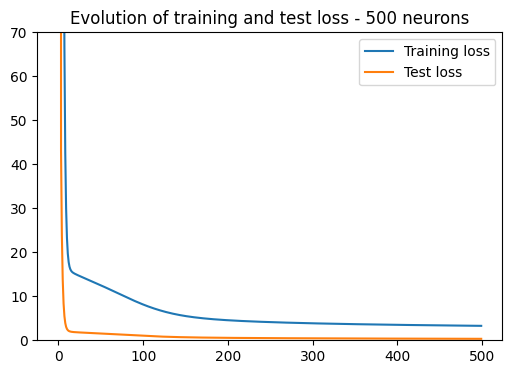

In [30]:
# Plot training and test loss
plt.figure(figsize=(6, 4))
plt.plot(losses1, label="Training loss")
plt.plot(losses1_test, label="Test loss")
plt.title('Evolution of training and test loss - 500 neurons')
plt.ylim(top=70, bottom=0.0)
plt.legend()
plt.show()

Now let's try a new model with more neurons in the hidden layer. We use 1000 neurons, and follow the same steps as before:

In [31]:
model2 = Net(D_in, 1000, D_out)

In [32]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

In [33]:
losses2 = []

for t in range(500):
    y_pred = model2(X_train)

    loss = criterion(y_pred, y_train)
    losses2.append(loss.item())

    if torch.isnan(loss):
        break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Let's visualize the evolution of the training loss for the two models:

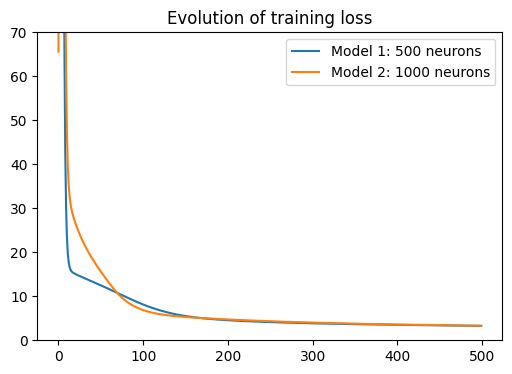

In [34]:
# Plot training and test loss
plt.figure(figsize=(6, 4))
plt.plot(losses1, label="Model 1: 500 neurons")
plt.plot(losses2, label="Model 2: 1000 neurons")
plt.title('Evolution of training loss')
plt.ylim(top=70, bottom=0.0)
plt.legend()
plt.show()

Let's compare the MSE loss on the test data:

In [35]:
# prediction for model 1
model1_pred = model1(X_test)
print("MSE loss for model 1: ", criterion(model1_pred, y_test))
# prediction for model 2
model2_pred = model2(X_test)
print("MSE loss for model 2: ", criterion(model2_pred, y_test))

MSE loss for model 1:  tensor(0.3332, grad_fn=<MseLossBackward0>)
MSE loss for model 2:  tensor(0.3359, grad_fn=<MseLossBackward0>)


What do you think?

## Solution: Predict the streams of a song with a 2 layer neural network

Based on this dataset ([link](https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_5/data/spotify.csv)) imported from kaggle, create a Neural Network that will predict the streams of a song based on its bpm, key, danceability, valence, energy, acousticness, instrumentalness, liveness, and speechiness. (Hint: if there are some errors, try to copy/paste them in Google to see some solutions.)

In [36]:
#import the dataset
df_lab = pd.read_csv("https://raw.githubusercontent.com/JasminaZHAW/MLDM2/main/labs/data/spotify.csv", encoding='latin-1', index_col="Unnamed: 0")
display(df_lab)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,LALA,Myke Towers,1.0,2023.0,3.0,23.0,1474.0,48.0,133716286.0,48.0,...,92.0,C#,Major,71.0,61.0,74.0,7.0,0.0,10.0,4.0
1,vampire,Olivia Rodrigo,1.0,2023.0,6.0,30.0,1397.0,113.0,140003974.0,94.0,...,138.0,F,Major,51.0,32.0,53.0,17.0,0.0,31.0,6.0
2,Cruel Summer,Taylor Swift,1.0,2019.0,8.0,23.0,7858.0,100.0,800840817.0,116.0,...,170.0,A,Major,55.0,58.0,72.0,11.0,0.0,11.0,15.0
3,WHERE SHE GOES,Bad Bunny,1.0,2023.0,5.0,18.0,3133.0,50.0,303236322.0,84.0,...,144.0,A,Minor,65.0,23.0,80.0,14.0,63.0,11.0,6.0
4,Columbia,Quevedo,1.0,2023.0,7.0,7.0,714.0,43.0,58149378.0,25.0,...,100.0,F,Major,67.0,26.0,71.0,37.0,0.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,BackOutsideBoyz,Drake,1.0,2022.0,11.0,4.0,1045.0,0.0,93367537.0,8.0,...,142.0,F,Minor,85.0,40.0,43.0,4.0,0.0,39.0,32.0
436,The Great War,Taylor Swift,1.0,2022.0,10.0,21.0,1274.0,0.0,181382590.0,1.0,...,96.0,F,Major,57.0,55.0,74.0,22.0,0.0,8.0,4.0
437,My Mind & Me,Selena Gomez,1.0,2022.0,11.0,3.0,953.0,0.0,91473363.0,61.0,...,144.0,A,Major,60.0,24.0,39.0,57.0,0.0,8.0,3.0
438,Bigger Than The Whole Sky,Taylor Swift,1.0,2022.0,10.0,21.0,1180.0,0.0,121871870.0,4.0,...,166.0,F#,Major,42.0,7.0,24.0,83.0,1.0,12.0,6.0


In [40]:
# select only the columns that you need based on the problem specification and store them in a dataframe
df_lab_num = df_lab[['streams', 'bpm', 'key', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']]
display(df_lab_num)

,streams,bpm,key,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,133716286.0,92.0,C#,71.0,61.0,74.0,7.0,0.0,10.0,4.0
1,140003974.0,138.0,F,51.0,32.0,53.0,17.0,0.0,31.0,6.0
2,800840817.0,170.0,A,55.0,58.0,72.0,11.0,0.0,11.0,15.0
3,303236322.0,144.0,A,65.0,23.0,80.0,14.0,63.0,11.0,6.0
4,58149378.0,100.0,F,67.0,26.0,71.0,37.0,0.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...
435,93367537.0,142.0,F,85.0,40.0,43.0,4.0,0.0,39.0,32.0
436,181382590.0,96.0,F,57.0,55.0,74.0,22.0,0.0,8.0,4.0
437,91473363.0,144.0,A,60.0,24.0,39.0,57.0,0.0,8.0,3.0
438,121871870.0,166.0,F#,42.0,7.0,24.0,83.0,1.0,12.0,6.0


In [41]:
# Splitting training/test set
num_train, num_test = train_test_split(df_lab_num, test_size=0.1, random_state=1)

In [42]:
# encode 'key' feature that is non-numeric to numeric using LabelEncoder
le = LabelEncoder()
num_train['key'] = le.fit_transform(num_train['key'])
num_test['key'] = le.transform(num_test['key'])

In [43]:
# scale your data using MinMaxScaler
#Define the scaler
scaler = MinMaxScaler()
#Fit the scaler
scaler.fit(num_train)
#Transform the train and the test set
num_train.loc[:,:] = scaler.transform(num_train)
num_test.loc[:,:] = scaler.transform(num_test)

In [44]:
# Extract features and output
numeric_x_columns = list(num_train.columns)
numeric_x_columns.remove("streams")
X_train_df_lab = num_train[numeric_x_columns]
y_train_df_lab = pd.DataFrame(num_train["streams"])
X_test_df_lab = num_test[numeric_x_columns]
y_test_df_lab = pd.DataFrame(num_test["streams"])

In [45]:
# Transform the data into tensor
X_train_lab = torch.tensor(X_train_df_lab.values, dtype=torch.float)
y_train_lab = torch.tensor(y_train_df_lab.values, dtype=torch.float)
X_test_lab = torch.tensor(X_test_df_lab.values, dtype=torch.float)
y_test_lab = torch.tensor(y_test_df_lab.values, dtype=torch.float)

Now create a Neural Net class with two hidden layer using the ReLU activation in both of them:

In [46]:
class Net_lab(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net_lab, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)        # Linear transformation for first hidden layer
        self.linear2 = nn.Linear(H1, H2)          # Linear transformation for second hidden layer
        self.linear3 = nn.Linear(H2, D_out)       # Linear transformation for output layer
        self.activation = nn.ReLU()               # Activation function for hidden layer

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))        # Hidden layer: linear transformation + ReLU
        y_pred = self.activation(self.linear2(y_pred))   # Hidden layer: linear transformation + ReLU
        y_pred = self.linear3(y_pred)                    # Output layer: linear transformation
        return y_pred

In [47]:
# give the right dimension to the input and output layers
D_in_lab, D_out_lab = X_train_lab.shape[1], y_train_lab.shape[1]

In [48]:
# Create a model with 100 neurons for both hidden layers
model_lab = Net_lab(D_in_lab, 100, 100, D_out_lab)

In [49]:
# calculate how many parameters the model has
params = sum(p.numel() for p in model_lab.parameters() if p.requires_grad)
display(params)

11201

In [50]:
# use the MSELoss() as the loss criterion and Adam() as the optimizer (search online the optimizer)
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# Adam optimizer for finding the weights of the network
optimizer = torch.optim.Adam(model_lab.parameters(), lr=1e-4)

Now create a loop to train your model (with 500 iterations), don't forget to save your loss criterion in order to plot it later !

In [51]:
losses_lab = []
losses_test_lab = []

for t in range(500):                # 500 iterations

    # Forward pass: compute prediction on training set
    y_pred_lab = model_lab(X_train_lab)

    # Compute loss
    loss = criterion(y_pred_lab, y_train_lab)
    print(t, loss.item())
    losses_lab.append(loss.item())
    if torch.isnan(loss):
        break

    # Compute gradient
    optimizer.zero_grad()
    loss.backward()

    # Update
    optimizer.step()

    # Compute loss on test set
    losses_test_lab.append(criterion(model_lab(X_test_lab), y_test_lab).item())

0 15.582260131835938
1 15.172860145568848
2 14.779776573181152
3 14.404058456420898
4 14.04552173614502
5 13.70451545715332
6 13.38107681274414
7 13.075119972229004
8 12.786784172058105
9 12.516739845275879
10 12.2647123336792
11 12.030698776245117
12 11.81405258178711
13 11.614477157592773
14 11.430974960327148
15 11.263542175292969
16 11.112374305725098
17 10.976325035095215
18 10.855032920837402
19 10.748058319091797
20 10.654756546020508
21 10.574108123779297
22 10.505255699157715
23 10.447346687316895
24 10.39888858795166
25 10.359525680541992
26 10.32848834991455
27 10.30455493927002
28 10.286160469055176
29 10.272372245788574
30 10.262150764465332
31 10.254528045654297
32 10.248544692993164
33 10.24356460571289
34 10.239068984985352
35 10.234784126281738
36 10.230093002319336
37 10.22472095489502
38 10.218429565429688
39 10.211420059204102
40 10.203198432922363
41 10.193672180175781
42 10.182866096496582
43 10.171002388000488
44 10.158324241638184
45 10.144866943359375
46 10.130

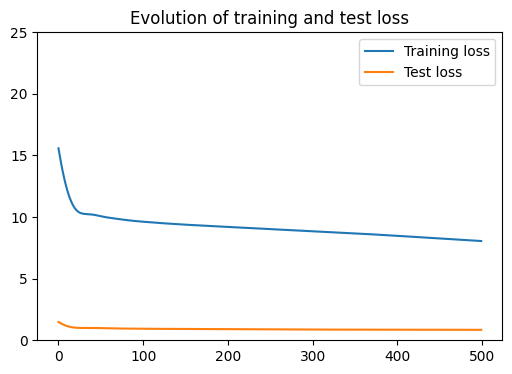

In [52]:
# Plot training and test loss
plt.figure(figsize=(6, 4))
plt.plot(losses_lab, label="Training loss")
plt.plot(losses_test_lab, label="Test loss")
plt.title('Evolution of training and test loss')
plt.ylim(top=25, bottom=0.0)
plt.legend()
plt.show()